## Сравнительный анализ робастных оценок

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats as sps
import matplotlib.gridspec as gridspec
import itertools
import math
from math import log

import scipy as sp

import sklearn
from sklearn import datasets

%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

np.random.seed(33)

### Распределения шумов

In [2]:
def Tukey_distrib(num, alpha, scale, outlier_multiplier, mean=0):
    eps = np.random.normal(mean, scale, num)
    for i in range(num):
        if np.random.binomial(1, alpha, 1)[0] == 1:
            eps[i] = np.random.normal(mean, scale * outlier_multiplier)
    return eps


def Student_distrib(num, degree):
    eps = sps.t.rvs(df=degree, size=num)
    return eps


def two_humped_distrib(num, distance):
    eps = np.random.normal(-distance / 2, 1, num)
    for i in range(num):
        if np.random.binomial(1, 0.5, 1)[0] == 1:
            eps[i] = np.random.normal(distance / 2, 1)
    return eps

### Функции потерь и их производные

In [3]:
def Tukey_loss(t, delta=4.6851):
    if abs(t) < delta:
        return  delta**2 / 6 * (1 - (1 - (t / delta)**2)**3)
    return delta**2 / 6


def Huber_loss(t, delta=1.345):
    if abs(t) < delta:
        return t**2 / 2
    return delta * (abs(t) - delta / 2)


def Cauchy_loss(t, delta=2.3849):
    return delta / 2 * log(1 + (t / delta)**2)


def Welsch_loss(t, delta=2.3849):
    return delta**2 / 2 * (1 - math.e**(-(t / delta)**2))

In [4]:
def der_a_Huber(t, delta=1.345):
    if abs(t) > delta:
        return delta * np.sign(t)
    return t


def der_a_Tukey(t, delta=4.6851):
    if abs(t) > delta:
        return 0
    return t / 6 * ((t / delta)**2 - 1)**2


def der_a_Cauchy(t, delta=2.3849):
    return t / (1 + (t / delta)**2)


def der_a_Welsch(t, delta=2.3849):
    return t * math.e**(-(t / delta)**2)

Применение МНК

In [5]:
def least_squares_solution(X, y):
    a_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    return a_hat

Разметка графика

In [6]:
def graph(xlabel, ylabel, title):
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.title(title, size=15)

Значения независимых переменных, а также коллекции функций потерь, их производных и обозначений

In [7]:
x = np.random.uniform(-5, 5, 100)

In [29]:
derivatives = [der_a_Huber, der_a_Tukey, der_a_Cauchy, der_a_Welsch]
losses = [Huber_loss, Tukey_loss, Cauchy_loss, Welsch_loss]
designations = [('OLS', 'y', '-'), ('Huber', 'b', '-.'), ('Tukey', 'r', '--'),
                ('Cauchy', 'g', '-.'), ('Welsh', 'black', ':')]
a = np.array([1, 1])

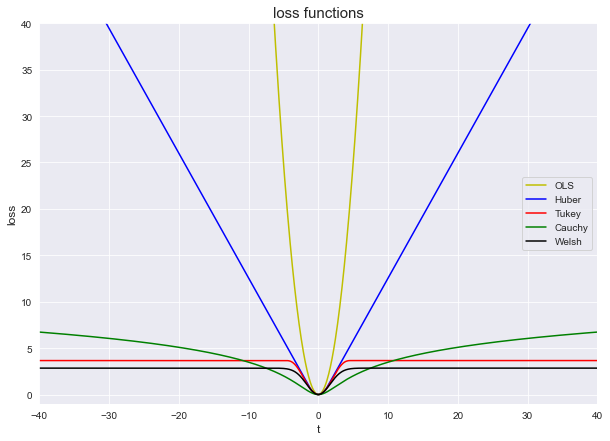

In [9]:
lns = np.linspace(-40, 40, 1000)
plt.figure(figsize=(10, 7))
plt.xlim((-40, 40))
plt.ylim((-1, 40))
graph('t', 'loss', 'loss functions')
plt.plot(lns, lns**2, color='y', label="OLS")
for loss, des in zip(losses, designations[1:]):
    plt.plot(lns, [loss(i) for i in lns], color=des[1], label=des[0])
plt.legend()
plt.show()

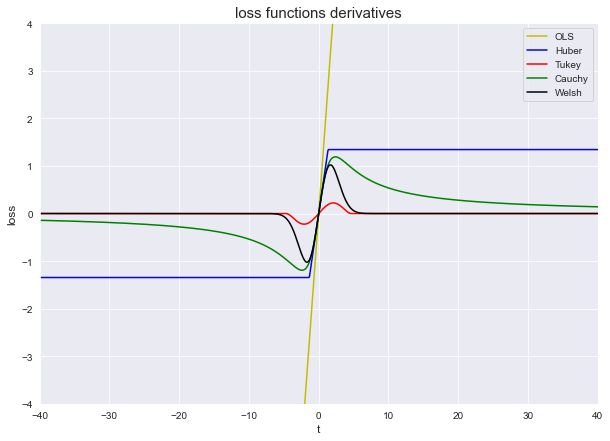

In [10]:
lns = np.linspace(-40, 40, 1000)
plt.figure(figsize=(10, 7))
plt.xlim((-40, 40))
plt.ylim((-4, 4))
graph('t', 'loss', 'loss functions derivatives')
plt.plot(lns, 2 * lns, color='y', label="OLS")
for loss, des in zip(derivatives, designations[1:]):
    plt.plot(lns, [loss(i) for i in lns], color=des[1], label=des[0])
plt.legend()
plt.show()

In [11]:
def gradient_descent(x, y, der_a, a_hat=np.array([0, 0], dtype=float), learning_rate=0.001, steps=100000):
    """
    Градиентный спуск для робастных М-оценок.
    """
    prev_a_hat = np.copy(a_hat)
    for step in range(steps):
        predicted = a_hat[0] + a_hat[1] * x
        residuals = y - predicted
        a_hat[0] -= learning_rate * np.sum(-1 * der_a(i) for i in residuals)
        a_hat[1] -= learning_rate * np.sum(-j * der_a(i) for i, j in zip(residuals, x))
        if max(abs(prev_a_hat - a_hat)) < 0.00001:
            break
        prev_a_hat = np.copy(a_hat)
    return a_hat

In [12]:
def avg(x, a, repeats, num, func, params, derivatives, loss=mean_squared_error):
    """
    Получение усредненной по количеству моделирований (repeats)
    суммы квадратов отклонений оценок для каждого метода оценивания.
    """
    global_loss = np.zeros(len(derivatives) + 1)
    X = np.column_stack([np.ones(num), x.reshape((-1, 1))])
    for r in range(repeats):
        eps = func(*params)
        y = X @ a + eps
        OLS = least_squares_solution(X, y)
        global_loss[0] += loss(a, OLS)
        for i in range(len(derivatives)):
            global_loss[i+1] += loss(a, gradient_descent(x, y, derivatives[i], OLS))
    return global_loss / repeats

In [13]:
def distrib_graph(x_text, label, linsp, distrib, x, a, num, designations, derivatives, repeats=1000, y_params=(0.0, 0.03)):
    """
    Построение сравнительного графика оценок для одного изменяемого параметра распределения шумов.
    """
    graph(x_text, 'average sum of squared deviations', label + ' (' + str(num) + ' el.)')
    results = np.zeros(len(designations)).reshape((-1, 1))
    for i in linsp:
        # print(i, end=' ') # для отслеживания прогресса
        res = avg(x[:num], a, repeats, num, distrib, [num, i], derivatives)
        results = np.hstack([results, res.reshape((-1, 1))])
        # print(designations[np.argmin(res)][0]) # для отслеживания прогресса
    for res, des in zip(results, designations):
        plt.plot(linsp, res[1:], label=des[0], color=des[1])
    for i in range(1, len(linsp) + 1):
        arg = np.argmin(results[:, i])
        plt.scatter(linsp[i-1], results[arg][i], color=designations[arg][1])
    plt.ylim(y_params)
    plt.legend()
    plt.show()
    return results
    

def Tukey_distrib_points(x, a, num, designations, repeats=1000):
    """
    Построение сравнительного графика оценок для двух изменяемых параметров распределения Тьюки.
    """
    outlier_occurence = np.linspace(0, 0.2, 11)
    outlier_multiplier = np.linspace(2, 10, 9)
    best = [False] * len(designations)
    plt.figure(figsize=(12,6))
    graph('outlier occurence', 'outlier multiplier', 'Tukey distribution' + ' (' + str(num) + ' el.)')
    plt.xlim([-0.02, 0.26])
    plt.ylim([0, 11])
    for i in outlier_occurence:
        #print(i) # для отслеживания прогресса
        for j in outlier_multiplier:
            res = avg(x[:num], a, repeats, num, Tukey_distrib, [num, i, 1, j], derivatives)
            idx = np.argmin(res)
            if best[idx]:
                plt.scatter(i, j, color=designations[idx][1])
            else:
                plt.scatter(i, j, color=designations[idx][1], label=designations[idx][0])
                best[idx] = True
    plt.legend(loc='upper right', fontsize=15)
    plt.show()

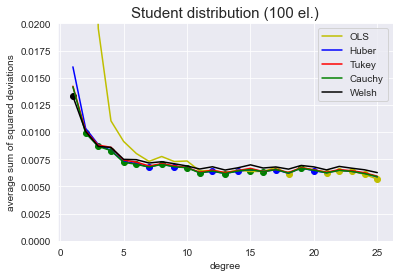

In [ ]:
results = distrib_graph('degree', 'Student distribution (100 el.)', np.linspace(1, 25, 25),
              Student_distrib, x, a, 100, designations, derivatives)

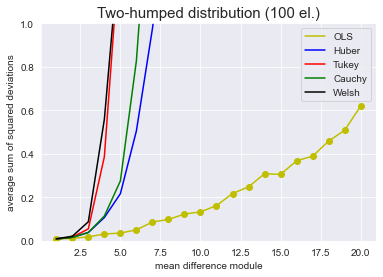

In [ ]:
results = distrib_graph('mean difference module', 'Two-humped distribution', np.linspace(1, 20, 20),
              two_humped_distrib, x, a, 100, designations, derivatives, y_params=(0.0, 1))

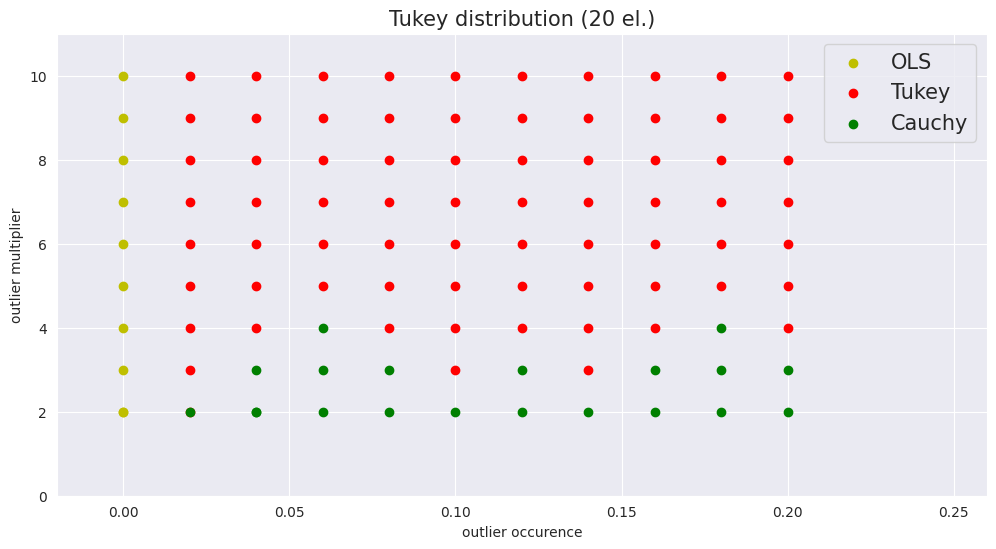

In [ ]:
Tukey_distrib_points(x, a, 20, designations)

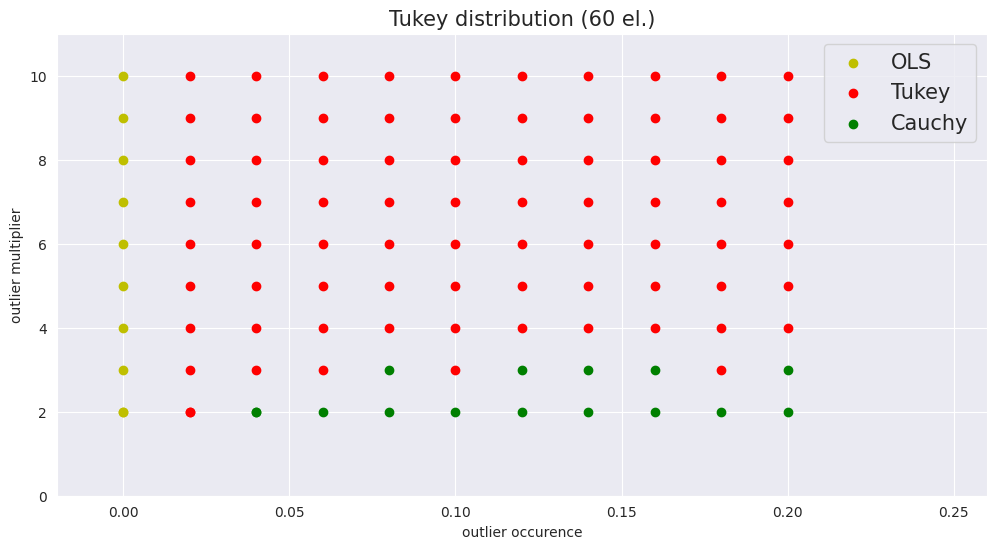

In [ ]:
Tukey_distrib_points(x, a, 60, designations)

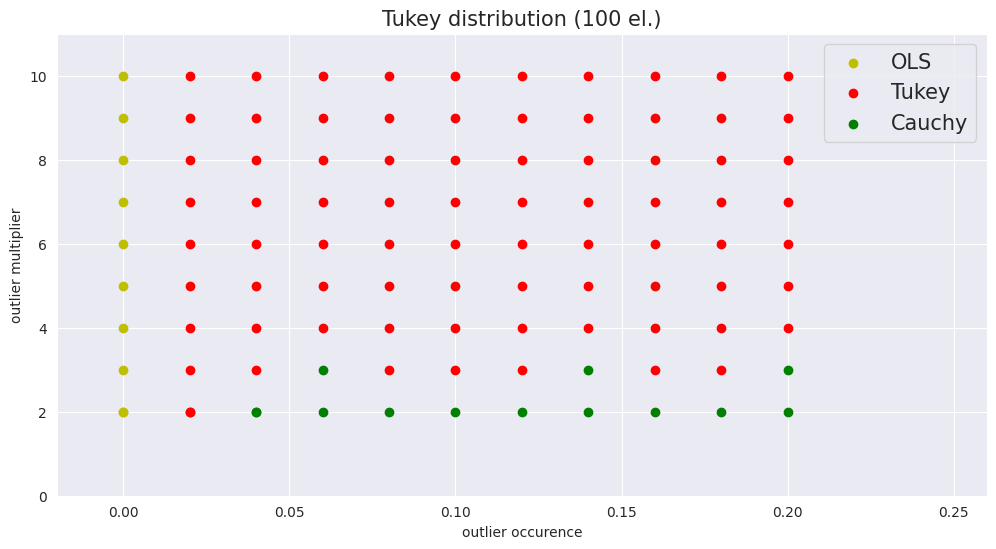

In [ ]:
Tukey_distrib_points(x, a, 100, designations)

## Реальные данные

In [89]:
def predict(X, y, derivatives, designations, graph_params, outlier_indexes=None, labels=None):
    plt.figure(figsize=(11, 7))
    graph(*graph_params)
    x = np.linspace(min(X), max(X), 100)
    mses = []
    evals = least_squares_solution(np.column_stack([np.ones(X.shape[0]), X.reshape(-1, 1)]), y)
    ols = np.array(evals)
    for der in derivatives:
        a_hat = gradient_descent(X, y, der, a_hat=ols)
        evals = np.vstack([evals, a_hat])
    plt.scatter(X, Y)
    if outlier_indexes:
        for i in outlier_indexes:
            plt.scatter(X[i], Y[i], color='r')
    if labels is not None:
        for i, j, label in zip(X, y, labels):
            plt.text(i, j, label)
    for ev, des in zip(evals, designations):
        plt.plot(x, ev[0] + x * ev[1], label=des[0], color=des[1], linestyle=des[2])
    plt.legend()
    plt.show()

### Ирисы Фишера

In [81]:
df = sklearn.datasets.load_iris(as_frame=True).frame
df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [82]:
X_all = df['sepal width (cm)'][:].to_numpy()
Y_all = df['sepal length (cm)'][:].to_numpy()

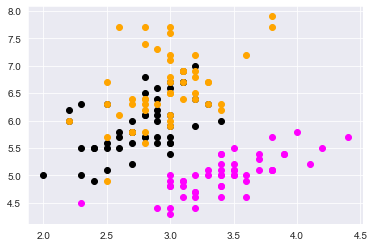

In [83]:
for i in range(X_all.shape[0]):
    if df['target'][i] == 0:
        plt.scatter(X_all[i], Y_all[i], color='magenta')
    elif df['target'][i] == 1:
        plt.scatter(X_all[i], Y_all[i], color='black')
    elif df['target'][i] == 2:
        plt.scatter(X_all[i], Y_all[i], color='orange')
plt.show()

In [84]:
X = df['sepal width (cm)'][40:].to_numpy()
Y = df['sepal length (cm)'][40:].to_numpy()

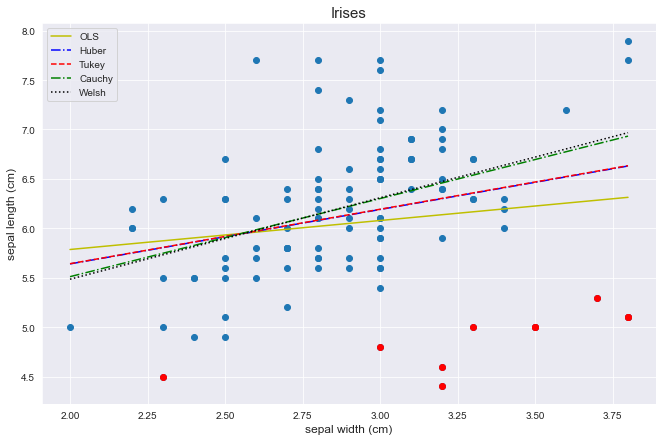

In [88]:
predict(X, Y, derivatives, designations, ['sepal width (cm)', 'sepal length (cm)', 'Irises'], outlier_indexes=range(10))

### ВВП и безработица

In [90]:
df = pd.read_excel(r'gdp_vs_unemployment.xlsx')
df.head(5)

,Country Name,unemployment,gdp
0,Singapore,3.10,65831.189431
1,Netherlands,3.38,52476.273253
2,United States,3.67,65120.394663
3,Norway,3.69,75719.752897
4,Austria,4.56,50070.403348


In [91]:
X = df['unemployment'][:].to_numpy()
Y = df['gdp'][:].to_numpy()

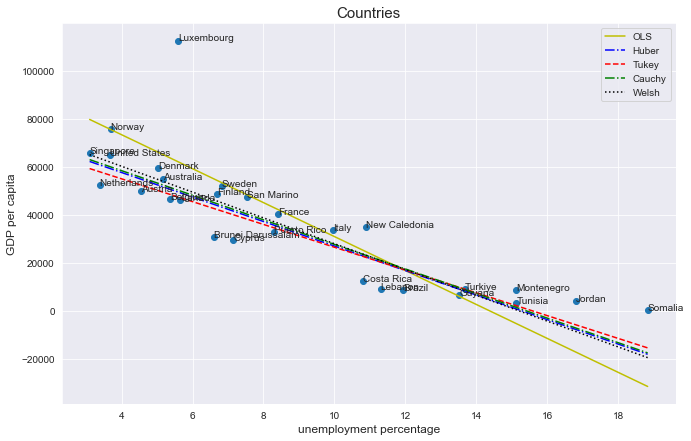

In [92]:
predict(X, Y, derivatives, designations, ['unemployment percentage', 'GDP per capita', 'Countries'], labels=df['Country Name'])